# Урок 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

**Задание 1:**

**Отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno
import xgboost as xgb


Загрузка данных

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    return pd.read_csv(csv_path)

In [3]:
train = load_data("assignment_2_train.csv")
test = load_data("assignment_2_test.csv")

In [4]:
#Размерности датасетов
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


Получение значения сводной статистикам по всем значениям train, test

In [5]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [6]:
test.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.000010e+05,100001.000000,1.000010e+05,100001.000000,100001.000000,98325.000000,99185.000000,98701.000000,88300.000000,88300.000000,...,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000
mean,3.337000e+06,0.038040,8.696663e+06,140.674821,9882.200528,357.652672,153.271785,198.466672,289.507758,86.863941,...,0.192944,81.733429,123.824365,91.572815,6.744021,36.245940,11.969737,47.597468,52.675413,48.497675
std,2.886795e+04,0.191293,7.603909e+05,240.272633,4867.290775,156.984512,11.512903,41.495035,101.589641,2.143002,...,0.606917,715.898781,777.526194,718.203590,214.832591,269.734936,216.315923,597.985868,600.451426,598.024560
min,3.287000e+06,0.000000,7.415038e+06,0.251000,1004.000000,100.000000,100.000000,100.000000,104.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.312000e+06,0.000000,8.023328e+06,44.529000,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.337000e+06,0.000000,8.630067e+06,73.970000,9633.000000,360.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.362000e+06,0.000000,9.346592e+06,134.950000,14065.000000,500.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,79.750000,39.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.387000e+06,1.000000,1.009155e+07,5543.230000,18395.000000,600.000000,229.000000,237.000000,536.000000,96.000000,...,6.000000,35176.500000,35176.500000,35176.500000,12307.500000,12307.500000,12307.500000,25000.000000,25000.000000,25000.000000


In [7]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получение числовых признаков

In [8]:
numerical_features = train.select_dtypes(exclude=["object"])
print(f"count of numeric_features {numerical_features.shape[1]}")

discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in ["TransactionID"] + ["isFraud"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

count of numeric_features 380
Discrete Variables Count: 180


In [9]:
numerical_features = numerical_features.drop(["TransactionID", "isFraud"], axis=1)


In [10]:
numerical_features.head(8)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,86510,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,86522,159.0,12308,360.0,150.0,166.0,126.0,87.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,86529,422.5,12695,490.0,150.0,226.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Анализ и Обработка пропусков признаков кроме целевого (средними по столбцу)

In [11]:
def check_missings_using_horizontalbars(ds,top=30):
    missing_values = ds.isnull().sum(axis=0).reset_index()
    missing_values.columns = ['column_name', 'missing_count']
    missing_values = missing_values.loc[missing_values['missing_count']>0]
    missing_values = missing_values.sort_values(by='missing_count').head(top)
    
    print("число признаков с пропусками", len(missing_values))
    
    if len(missing_values)==0:
        return
    
    ind = np.arange(missing_values.shape[0])
    fig, axes = plt.subplots(figsize=(15,8))
    rects = axes.barh(ind, missing_values.missing_count.values, height = 0.9)
    axes.set_yticks(ind)
    axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
    axes.set_title('Missing Observations count')
    axes.set_xlabel('Missing Observations count')      

число признаков с пропусками 30


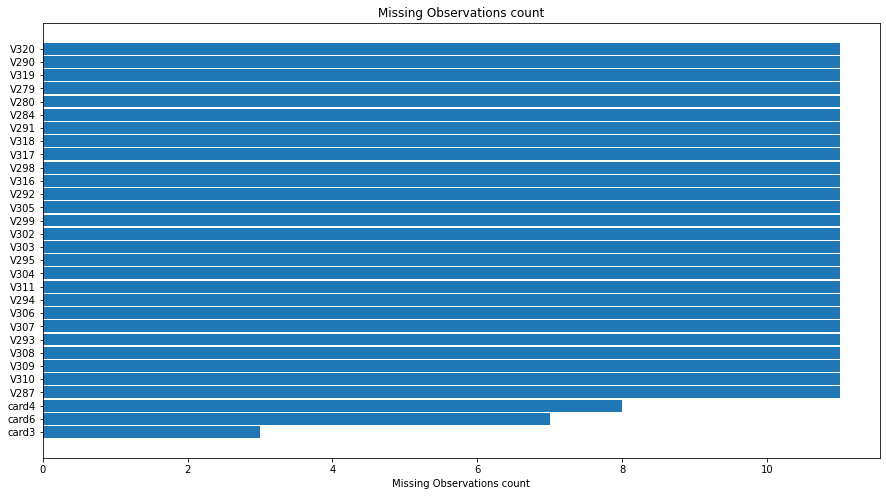

In [12]:
check_missings_using_horizontalbars(train)

In [13]:
#Заменяем на среднии
numerical_features = numerical_features.fillna(numerical_features.mean())

In [14]:
numerical_features.head(8)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
1,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
2,86469,59.0,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
3,86499,50.0,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
4,86506,50.0,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,86510,49.0,5937,555.000000,150.0,226.0,272.0,87.0,36.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
6,86522,159.0,12308,360.000000,150.0,166.0,126.0,87.0,0.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
7,86529,422.5,12695,490.000000,150.0,226.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421


In [15]:
data=numerical_features

Анализ целевого признака

In [16]:
target=train['isFraud']

In [17]:
print("число уникальных y:",train['isFraud'].nunique())
print("уникальные y:",train['isFraud'].unique())

число уникальных y: 2
уникальные y: [0 1]


In [18]:
dataset_target = pd.DataFrame(train['isFraud'])

In [19]:
check_missings_using_horizontalbars(dataset_target)

число признаков с пропусками 0


Тренировка модели где используется Hold-Out валидация (валидация на отложенной выборке)

In [20]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [21]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,    
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [22]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [23]:
model_xgb1 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=100,    
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.64989	valid-auc:0.65041
[10]	train-auc:0.78752	valid-auc:0.78781
[20]	train-auc:0.82659	valid-auc:0.82436
[30]	train-auc:0.85870	valid-auc:0.85517
[40]	train-auc:0.87263	valid-auc:0.86607
[50]	train-auc:0.88066	valid-auc:0.87421
[60]	train-auc:0.88692	valid-auc:0.87941
[70]	train-auc:0.88976	valid-auc:0.88225
[80]	train-auc:0.89230	valid-auc:0.88453
[90]	train-auc:0.89526	valid-auc:0.88701
[100]	train-auc:0.89833	valid-auc:0.88950
[110]	train-auc:0.90056	valid-auc:0.89122
[120]	train-auc:0.90282	valid-auc:0.89325
[130]	train-auc:0.90441	valid-auc:0.89406
[140]	train-auc:0.90561	valid-auc:0.89567
[150]	train-auc:0.90656	valid-auc:0.89659
[160]	train-auc:0.90759	valid-auc:0.89786
[170]	train-auc:0.90854	valid-auc:0.89873
[180]	train-auc:0.90863	valid-auc:0.89884
[190]	train-auc:0.90863	valid-auc:0.89884
[200]	train-auc:0.90863	valid-auc:0.89884
[210]	train-auc:0.90863	valid-auc:0.89884
[220]	train-auc:0.90863	valid-auc:0.89884
[230]	train-auc:0.90863	valid-auc:0.89887
[24

**Задание 2:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.**

In [24]:
categorical_features = train.select_dtypes(include=["object"])

In [25]:
categorical_features

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,W,mastercard,debit,gmail.com,NaN,T,T,F,M1,T,F,NaN,NaN,NaN
179996,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN
179997,W,mastercard,debit,gmail.com,NaN,T,T,T,M0,T,F,NaN,NaN,NaN
179998,W,visa,debit,NaN,NaN,NaN,NaN,NaN,M1,T,T,NaN,NaN,NaN


In [26]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
ProductCD        180000 non-null object
card4            179992 non-null object
card6            179993 non-null object
P_emaildomain    151560 non-null object
R_emaildomain    60300 non-null object
M1               61749 non-null object
M2               61749 non-null object
M3               61749 non-null object
M4               83276 non-null object
M5               61703 non-null object
M6               105652 non-null object
M7               31652 non-null object
M8               31652 non-null object
M9               31652 non-null object
dtypes: object(14)
memory usage: 19.2+ MB


In [27]:
for col in categorical_features.columns:
    print(col, categorical_features[col].nunique())

ProductCD 5
card4 4
card6 4
P_emaildomain 59
R_emaildomain 60
M1 2
M2 2
M3 2
M4 3
M5 2
M6 2
M7 2
M8 2
M9 2


In [28]:
from sklearn.preprocessing import OneHotEncoder

def handle_categorical_data(data, categorical_features):
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for col in categorical_features.columns:
        ohe_ftrs = enc.fit_transform(categorical_features[col].values.reshape(-1,1))
        tmp = pd.DataFrame(ohe_ftrs, columns = [col + '_' + str(i) for i in range(ohe_ftrs.shape[1])])
        data = pd.concat([data, tmp], axis=1)
    return data
    

In [29]:
data = handle_categorical_data(data, categorical_features)

In [30]:
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [32]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [33]:
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=100,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.64989	valid-auc:0.65041
[10]	train-auc:0.78752	valid-auc:0.78781
[20]	train-auc:0.83680	valid-auc:0.83101
[30]	train-auc:0.86550	valid-auc:0.86127
[40]	train-auc:0.87563	valid-auc:0.86921
[50]	train-auc:0.88718	valid-auc:0.88015
[60]	train-auc:0.89568	valid-auc:0.88621
[70]	train-auc:0.90068	valid-auc:0.89126
[80]	train-auc:0.90436	valid-auc:0.89418
[90]	train-auc:0.90641	valid-auc:0.89604
[100]	train-auc:0.90821	valid-auc:0.89755
[110]	train-auc:0.91062	valid-auc:0.89929
[120]	train-auc:0.91183	valid-auc:0.90047
[130]	train-auc:0.91336	valid-auc:0.90161
[140]	train-auc:0.91548	valid-auc:0.90340
[150]	train-auc:0.91675	valid-auc:0.90472
[160]	train-auc:0.91717	valid-auc:0.90520
[170]	train-auc:0.91717	valid-auc:0.90520
[180]	train-auc:0.91717	valid-auc:0.90520
[190]	train-auc:0.91717	valid-auc:0.90520
[200]	train-auc:0.91717	valid-auc:0.90520
[210]	train-auc:0.91717	valid-auc:0.90520
[220]	train-auc:0.91717	valid-auc:0.90520
[230]	train-auc:0.91717	valid-auc:0.90520
[24

**Задание 4:**

**для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [34]:
data=numerical_features
data.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
1,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
2,86469,59.0,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
3,86499,50.0,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
4,86506,50.0,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:
!pip install lightgbm

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [37]:
import numpy as np
import lightgbm as lgb

In [38]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [42]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 8,
    "seed": 27
}

In [45]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model_lgb1 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=100
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30620
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.890232	valid_1's auc: 0.880727
[200]	training's auc: 0.910154	valid_1's auc: 0.893414
[300]	training's auc: 0.925021	valid_1's auc: 0.9038
[400]	training's auc: 0.934749	valid_1's auc: 0.912261
[500]	training's auc: 0.943938	valid_1's auc: 0.918967
[600]	training's auc: 0.950469	valid_1's auc: 0.923631
[700]	training's auc: 0.954867	valid_1's auc: 

**Задание 5:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.**

In [46]:
data = handle_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [47]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [48]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model_lgb2 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=100,
    verbose_eval=100
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30880
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 506
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898147	valid_1's auc: 0.890527
[200]	training's auc: 0.915231	valid_1's auc: 0.901965
[300]	training's auc: 0.932615	valid_1's auc: 0.915138
[400]	training's auc: 0.942762	valid_1's auc: 0.922211
[500]	training's auc: 0.952281	valid_1's auc: 0.929013
[600]	training's auc: 0.95856	valid_1's auc: 0.933389
[700]	training's auc: 0.963117	valid_1's auc:

**Задание 6:** 

**обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.**

In [51]:
cat_feats =[]
for col in categorical_features.columns:
    cat_feats.append(col)
cat_feats

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [91]:
data=numerical_features

In [92]:
categorical_features.fillna(0)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,0,0,T,T,T,M2,F,T,0,0,0
1,W,mastercard,credit,gmail.com,0,0,0,0,M0,T,T,0,0,0
2,W,visa,debit,outlook.com,0,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,0,0,0,0,M0,T,F,0,0,0
4,H,mastercard,credit,gmail.com,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,W,mastercard,debit,gmail.com,0,T,T,F,M1,T,F,0,0,0
179996,W,mastercard,debit,yahoo.com,0,0,0,0,0,0,T,0,0,0
179997,W,mastercard,debit,gmail.com,0,T,T,T,M0,T,F,0,0,0
179998,W,visa,debit,0,0,0,0,0,M1,T,T,0,0,0


In [93]:
from sklearn.preprocessing import LabelEncoder

def handle_by_simple_method_categorical_data(data, categorical_features):
    enc = LabelEncoder()
    for col in categorical_features.columns:
        ohe_ftrs = enc.fit_transform(categorical_features[col])
        tmp = pd.DataFrame(ohe_ftrs,columns = [col])
        data = pd.concat([data, tmp], axis=1)
    return data

In [94]:
data=handle_by_simple_method_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,60,1,1,1,2,0,1,2,2,2
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,60,2,2,2,0,1,1,2,2,2
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,60,1,1,1,0,0,0,0,0,0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,60,2,2,2,0,1,0,2,2,2
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,60,2,2,2,3,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,60,1,1,0,1,1,0,2,2,2
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,60,2,2,2,3,2,1,2,2,2
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,60,1,1,1,0,1,0,2,2,2
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,60,2,2,2,1,1,1,2,2,2


In [95]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 36000 rows, 392 cols


In [96]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train, categorical_feature=cat_feats
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid, categorical_feature=cat_feats
)

In [97]:
model_lgb3 = lgb.train(
    params=params,
    train_set=dtrain,
    categorical_feature=cat_feats,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],    
    early_stopping_rounds=100,
    verbose_eval=100
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30793
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 390


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.902641	valid_1's auc: 0.890744
[200]	training's auc: 0.919803	valid_1's auc: 0.903682
[300]	training's auc: 0.934527	valid_1's auc: 0.914347
[400]	training's auc: 0.944809	valid_1's auc: 0.921889
[500]	training's auc: 0.953024	valid_1's auc: 0.927771
[600]	training's auc: 0.95897	valid_1's auc: 0.932474
[700]	training's auc: 0.963471	valid_1's auc: 0.934947
[800]	training's auc: 0.967826	valid_1's auc: 0.936727
[900]	training's auc: 0.971018	valid_1's auc: 0.938631
[1000]	training's auc: 0.974306	valid_1's auc: 0.94093
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.974306	valid_1's auc: 0.94093


Выводы: по сравнению с ручным кодированиям через OneHotEncoder алгоритм существенно не выиграл, даже метрика auc: 0.942584 в случае ручного кодирования категорийных признаков на валидационном датасете лучше, чем при кодировании встроеннным методом lightgbm - auc: 0.94093, также требующего еще и предварительного преобразование в числовую форму, хотя на тренировочном датасете эта метрика немного лучше.

**Задание 7:**

**для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [98]:
data=numerical_features

In [99]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [107]:
!pip install catboost

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [108]:
import catboost as cb

In [142]:
cb_params = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.01    
}

In [116]:
model_cb1 = cb.CatBoostClassifier(**cb_params)
model_cb1.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6822113	test1: 0.6775167	best: 0.6775167 (0)	total: 42.4ms	remaining: 7m 3s
200:	test: 0.8611745	test1: 0.8562829	best: 0.8562846 (196)	total: 8.17s	remaining: 6m 38s
400:	test: 0.8730164	test1: 0.8674414	best: 0.8674583 (398)	total: 16.6s	remaining: 6m 37s
600:	test: 0.8825038	test1: 0.8745803	best: 0.8745803 (600)	total: 25.7s	remaining: 6m 41s
800:	test: 0.8869882	test1: 0.8790072	best: 0.8790074 (799)	total: 34.4s	remaining: 6m 34s
1000:	test: 0.8902843	test1: 0.8820183	best: 0.8820183 (1000)	total: 43s	remaining: 6m 26s
1200:	test: 0.8923284	test1: 0.8837487	best: 0.8837487 (1200)	total: 51.5s	remaining: 6m 17s
1400:	test: 0.8937563	test1: 0.8851274	best: 0.8851274 (1400)	total: 1m	remaining: 6m 8s
1600:	test: 0.8955161	test1: 0.8865608	best: 0.8865608 (1600)	total: 1m 8s	remaining: 6m 1s
1800:	test: 0.8973489	test1: 0.8881651	best: 0.8881651 (1800)	total: 1m 18s	remaining: 5m 59s
2000:	test: 0.8992490	test1: 0.8897158	best: 0.8897158 (2000)	total: 1m 28s	remaining: 5m 

**Задание 8:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.**

In [117]:
data = handle_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [118]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [119]:
model_cb2 = cb.CatBoostClassifier(**cb_params)
model_cb2.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6352077	test1: 0.6343132	best: 0.6343132 (0)	total: 37.7ms	remaining: 6m 17s
200:	test: 0.8626598	test1: 0.8576204	best: 0.8577980 (199)	total: 8.65s	remaining: 7m 1s
400:	test: 0.8760920	test1: 0.8705906	best: 0.8705906 (400)	total: 17.9s	remaining: 7m 9s
600:	test: 0.8883461	test1: 0.8804612	best: 0.8804612 (600)	total: 27.5s	remaining: 7m 9s
800:	test: 0.8940816	test1: 0.8857120	best: 0.8857127 (798)	total: 36.9s	remaining: 7m 3s
1000:	test: 0.8982188	test1: 0.8895548	best: 0.8895548 (1000)	total: 46.5s	remaining: 6m 57s
1200:	test: 0.9004713	test1: 0.8916825	best: 0.8916832 (1199)	total: 55.6s	remaining: 6m 47s
1400:	test: 0.9023239	test1: 0.8935801	best: 0.8935801 (1400)	total: 1m 4s	remaining: 6m 37s
1600:	test: 0.9038762	test1: 0.8950433	best: 0.8950604 (1594)	total: 1m 14s	remaining: 6m 28s
1800:	test: 0.9059834	test1: 0.8968787	best: 0.8968787 (1800)	total: 1m 24s	remaining: 6m 23s
2000:	test: 0.9081907	test1: 0.8988937	best: 0.8988937 (2000)	total: 1m 34s	remaining

**Задание 9:**

**обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.**

In [143]:
data=numerical_features

In [144]:
categorical_features=categorical_features.fillna('')

In [145]:
data = pd.concat([data, categorical_features], axis=1)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,,T,T,T,M2,F,T,,,
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,,,,,M0,T,T,,,
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,,T,T,T,M0,F,F,F,F,F
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,,,,,M0,T,F,,,
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,,T,T,F,M1,T,F,,,
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,,,,,,,T,,,
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,,T,T,T,M0,T,F,,,
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,,,,,M1,T,T,,,


In [146]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 36000 rows, 392 cols


In [147]:
model_cb3 = cb.CatBoostClassifier(**cb_params)
model_cb3.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], cat_features=cat_feats,plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6462261	test1: 0.6418749	best: 0.6418749 (0)	total: 236ms	remaining: 39m 20s
200:	test: 0.8617528	test1: 0.8578031	best: 0.8578031 (200)	total: 47.8s	remaining: 38m 49s
400:	test: 0.8775432	test1: 0.8711141	best: 0.8711141 (400)	total: 1m 45s	remaining: 42m 8s
600:	test: 0.8895773	test1: 0.8808271	best: 0.8808271 (600)	total: 2m 43s	remaining: 42m 41s
800:	test: 0.8959497	test1: 0.8866416	best: 0.8866416 (800)	total: 3m 42s	remaining: 42m 40s
1000:	test: 0.8990739	test1: 0.8895448	best: 0.8895448 (1000)	total: 4m 41s	remaining: 42m 14s
1200:	test: 0.9016443	test1: 0.8917747	best: 0.8917750 (1199)	total: 5m 41s	remaining: 41m 43s
1400:	test: 0.9033758	test1: 0.8932791	best: 0.8932797 (1399)	total: 6m 43s	remaining: 41m 16s
1600:	test: 0.9047715	test1: 0.8943678	best: 0.8943683 (1599)	total: 7m 44s	remaining: 40m 37s
1800:	test: 0.9063558	test1: 0.8954163	best: 0.8954202 (1797)	total: 8m 46s	remaining: 39m 58s
2000:	test: 0.9078548	test1: 0.8965075	best: 0.8965075 (2000)	total

Выводы: При обработке категориальных признаков встроенным методом в CatBoost результаты метрики roc-auc  получаются немного хуже.  для ручного кодирования лучший roc-auc=0.9135574214, а для кодирования встроенного в CatBoost лучший roc-auc=9132636778 (на n_estimators=10000)

**Задание 10:**

**построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.**

Задание будет сделано в ближайшее время, т.к сожалению не успеваю из-за огромности задания.